# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
       .builder \
       .appName("Sparkify-X") \
       .getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '36173'),
 ('spark.app.name', 'Sparkify-X'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1589482890158'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '3e7609394bb1'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [6]:
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
user_log.select("page").dropDuplicates().show(30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [8]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
col_list = user_log.schema.names

In [10]:
user_log.count()

286500

In [11]:
empty_strings_dict = {}
for col in col_list:
 empty_strings_dict[col] = user_log.filter(user_log[col] == '').count()   

In [12]:
null_val_dict = {}
for col in col_list:
 null_val_dict[col] = user_log.filter(user_log[col].isNull()).count()


In [13]:
null_val_dict

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [14]:
empty_strings_dict

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 8346}

In [15]:
#user_log = user_log.dropna(how = 'any', subset = ["userId", "sessionId"])
user_log.count()

286500

In [16]:
user_log = user_log.filter(user_log['userId'] != "")

In [17]:
user_log.count()

278154

In [18]:
user_log.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [19]:
total_locations = user_log.select("location").dropDuplicates().sort("location").count()

In [20]:
user_log.select("registration").dropDuplicates().sort("registration").show()

+-------------+
| registration|
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
|1531679695000|
+-------------+
only showing top 20 rows



In [21]:

num_levels = user_log.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [22]:
user_log.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [23]:
user_log.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [24]:
user_log.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [25]:
user_log.select("itemInSession").dropDuplicates().sort("status").show()


+-------------+
|itemInSession|
+-------------+
|          720|
|         1258|
|          278|
|          964|
|           26|
|          474|
|          243|
|           65|
|         1224|
|           29|
|         1277|
|          558|
|          418|
|          541|
|          270|
|          222|
|          730|
|          938|
|         1145|
|          293|
+-------------+
only showing top 20 rows



In [26]:
location = user_log.select("location").dropDuplicates().sort("location")

In [27]:
user_log.select("length").dropDuplicates().sort("length").show()


+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



In [28]:
user_log.select("sessionId").dropDuplicates().show()

+---------+
|sessionId|
+---------+
|       29|
|       26|
|      474|
|      964|
|     1697|
|     1806|
|     2040|
|     1950|
|     2214|
|      418|
|       65|
|      541|
|      558|
|     1010|
|     1224|
|     1277|
|     1258|
|     1360|
|     1840|
|     2173|
+---------+
only showing top 20 rows



In [29]:
#user_log.select(["page", "auth", "level","hour"]).filter(user_log.userId == "18").orderBy(user_log.hour).show(1000000)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [30]:
churned_users = user_log.select(["userId"]).filter(user_log.page == "Cancellation Confirmation")
churned_users = churned_users.toPandas()

churned_users = churned_users.userId.tolist()

In [31]:
churned_users

['18',
 '32',
 '125',
 '105',
 '17',
 '143',
 '101',
 '129',
 '121',
 '51',
 '87',
 '122',
 '12',
 '58',
 '73',
 '3',
 '106',
 '103',
 '28',
 '54',
 '29',
 '70',
 '53',
 '100011',
 '100001',
 '100024',
 '100006',
 '100019',
 '100003',
 '100023',
 '100005',
 '100017',
 '100025',
 '100009',
 '100012',
 '100013',
 '100022',
 '100014',
 '100015',
 '100021',
 '100007',
 '200001',
 '200024',
 '200011',
 '200021',
 '200018',
 '200015',
 '200017',
 '200016',
 '200020',
 '300007',
 '300001']

In [32]:
get_churn_users = udf(lambda x: 1 if( x in churned_users) else 0)
set_churn       = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0)

In [33]:
user_log = user_log.withColumn('Churn', get_churn_users("userId"))

In [34]:
user_log.select("Churn").dropDuplicates().show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



In [35]:
#get_churn = udf(lambda x: True if(x  == "Cancellation Confirmation") else False)
#user_log = user_log.withColumn('Churn', get_churn(user_log.page))

In [36]:
test = user_log.groupby(user_log.Churn).agg({"Churn":"count"})
test.show()

+-----+------------+
|Churn|count(Churn)|
+-----+------------+
|    0|      233290|
|    1|       44864|
+-----+------------+



In [37]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log = user_log.withColumn("month", get_month(user_log.ts))


In [38]:
user_log.take(2)


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn='0', hour='0', month='10'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', Churn='0', hour='0', month='10')]

In [39]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.Churn , user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [40]:
thumbs_up = user_log.filter(user_log.page == "Thumbs Up").groupby(user_log.Churn, user_log.hour ).count()
thumbs_dn = user_log.filter(user_log.page == "Thumbs Down").groupby(user_log.Churn,user_log.hour ).count()
advert = user_log.filter(user_log.page == "Roll Advert").groupby(user_log.Churn ,user_log.hour).count()
playlist = user_log.filter(user_log.page == "Add to Playlist").groupby(user_log.Churn,user_log.hour ).count()
downgrade = user_log.filter(user_log.page == "Downgrade").groupby(user_log.Churn,user_log.hour).count()
downgrade_month = user_log.filter(user_log.page == "Downgrade").groupby(user_log.Churn,user_log.month).count()
upgrade_month = user_log.filter(user_log.page == "Upgrade").groupby(user_log.Churn, user_log.month ).count()
ns = user_log.filter(user_log.page == "NextSong").groupby(user_log.Churn, user_log.month ).count()
c = user_log.filter(user_log.Churn == "1").groupby(user_log.month ).count()

#for i in churned_users:
#    c = user_log.select('userId', 'month').filter(user_log.userId == i)
#c = user_log.select('month').filter(user_log.Churn == "1").dropDuplicates().count()
#c.select('userId').dropDuplicates().show()
#.groupby(user_log.Churn == 'true').count()
c.show()


+-----+-----+
|month|count|
+-----+-----+
|   11| 7831|
|   10|37033|
+-----+-----+



Churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

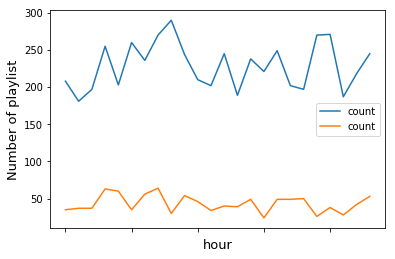

In [41]:
plist = playlist.toPandas()
plist.head()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of playlist', fontsize= 13)
plist.groupby('Churn').plot(x='hour', y='count', use_index=True , ax=ax)

  Churn month   count
1     0    10   88071
3     1    10   30031
0     1    11    6363
2     0    11  103639
4     0    12       4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 4
Data columns (total 3 columns):
Churn    5 non-null object
month    5 non-null object
count    5 non-null int64
dtypes: int64(1), object(2)
memory usage: 160.0+ bytes
None
  Churn month  count
4     0    12      4


(5, 3)

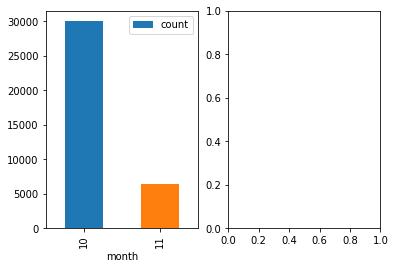

In [42]:
ns1 = ns.toPandas()
ns1.sort_values(by=['month'], inplace=True)
print(ns1.head())
print(ns1.info())
print(ns1[ns1['month']== str(12)])
fig,axes = plt.subplots(nrows=1, ncols=2)
#ax = plt.gca()
#figsize=(10,8)
#ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of songs', fontsize= 13)
nsgrp = ns1.groupby('Churn')
nsgrp.get_group('1').plot(x='month', y='count', kind = 'bar', use_index=True ,legend=True, ax=axes[0])


    
ns1[ns1['Churn'] == '0']['Churn'].value_counts()
ns1.shape
#.plot(x='month', kind = 'bar', use_index=True ,legend=True, ax=axes[1])
#ax.legend(["Non Churned Users", "Churned Users"])


  Churn month  count
1     0    10    227
3     1    10    105
0     1    11      7
2     0    11    160


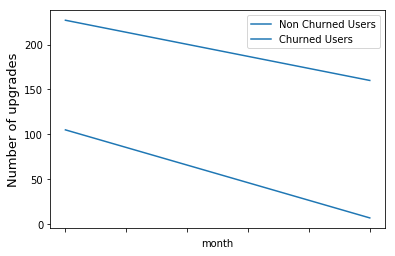

In [43]:
upgrade_month1 = upgrade_month.toPandas()
upgrade_month1.sort_values(by=['month'], inplace=True)
print(upgrade_month1.head())

ax = plt.gca()
#ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of upgrades', fontsize= 13)
upgrade_month1.groupby('Churn').plot(x='month', y='count', kind = 'line', use_index=True ,legend=True, subplots = True, ax=ax)
ax.legend(["Non Churned Users", "Churned Users"])

  Churn month  count
1     0    10    757
3     1    10    268
0     1    11     69
2     0    11    961
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
Churn    48 non-null object
hour     48 non-null object
count    48 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.2+ KB


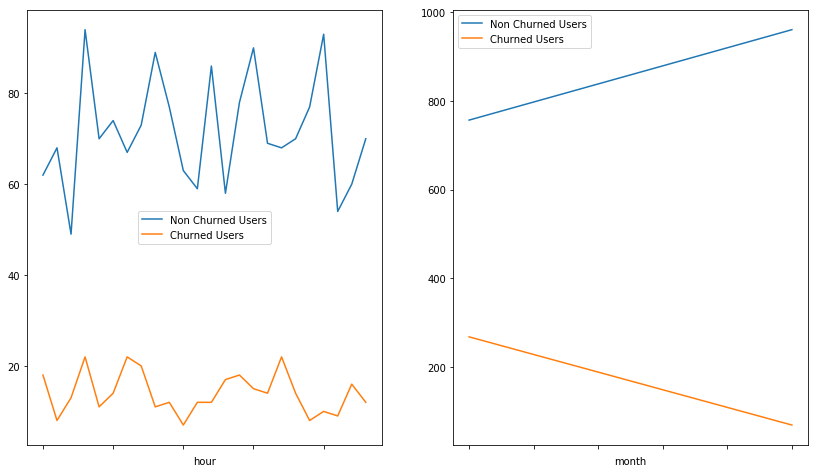

In [44]:
dngrade = downgrade.toPandas()
dngrade_month = downgrade_month.toPandas()
dngrade_month.sort_values(by=['month'], inplace=True)
print(dngrade_month.head())
dngrade.info()
fig,axes = plt.subplots(nrows=1, ncols=2)
figsize = (14, 8)
fontsize = 13
#ax.set_xlabel('Hours from 0-24', fontsize=13)
#ax.set_ylabel('Number of `downgrade', fontsize= 13)
dngrade.groupby('Churn').plot(x='hour', y='count', use_index=True ,figsize=figsize, legend=True, ax=axes[0])
dngrade_month.groupby('Churn').plot(x='month', y='count', kind='line', use_index=True ,legend=True, ax=axes[1])


axes[0].legend(["Non Churned Users", "Churned Users"]);
axes[1].legend(["Non Churned Users", "Churned Users"]);

Churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

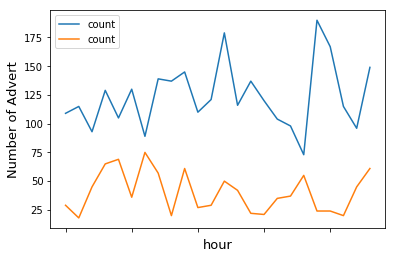

In [45]:
add = advert.toPandas()
add.head()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Advert', fontsize= 13)
add.groupby('Churn').plot(x='hour', y='count', use_index=True , ax=ax)

Churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

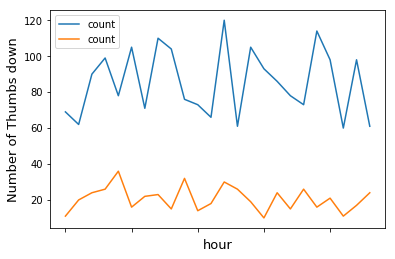

In [46]:
tdn = thumbs_dn.toPandas()
tdn.head()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Thumbs down', fontsize= 13)
tdn.groupby('Churn').plot(x='hour', y='count', use_index=True , ax=ax)

Churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

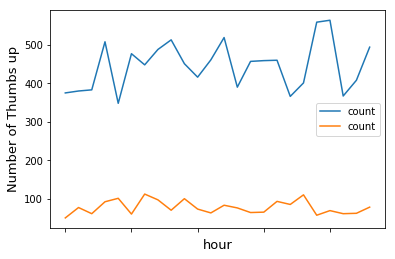

In [47]:
tups = thumbs_up.toPandas()
tups.head()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Thumbs up', fontsize= 13)
tups.groupby('Churn').plot(x='hour', y='count', use_index=True , ax=ax)

In [48]:
#songs_in_hour.select("Churn").dropDuplicates().show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
Churn    48 non-null object
hour     48 non-null object
count    48 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.2+ KB
None


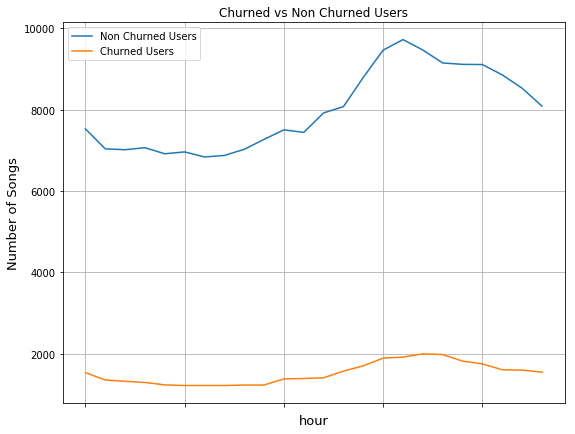

In [49]:
#churn_usr_songs = songs_in_hour.filter(songs_in_hour.Churn == 'true')
churn_usr_songs = songs_in_hour.toPandas()
print(churn_usr_songs.info())
churn_usr_songs['Churn'].value_counts()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Songs', fontsize= 13)

churn_usr_songs.groupby('Churn').plot(x='hour',y='count',title = 'Churned vs Non Churned Users' ,use_index=True,figsize = (9,7) ,legend = True, grid = True, ax=ax)
ax.legend(["Non Churned Users", "Churned Users"]);

  Churn hour  count
0     0    0   7527
1     1    0   1535
2     0    1   7035
3     1    1   1353
4     1    2   1322


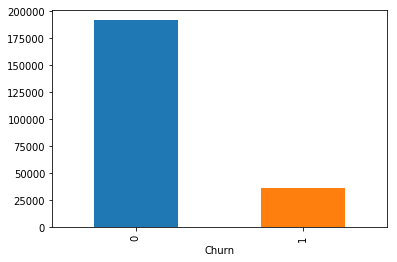

In [50]:
print(churn_usr_songs.head())
churn_usr_songs.groupby('Churn')['count'].sum().plot(kind='bar')
#x = churn_usr_songs.groupby('Churn')
#y = x.get_group('true')
#y.head()
#['count'].plot(kind='bar')

In [51]:
from datetime import datetime
from datetime import date
df_user_log     = user_log.toPandas()
df_user_log.info()
df_user_log['time'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). hour))
df_user_log['day'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). day))
df_user_log['month'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). month))
df_user_log['year'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). year))
print(df_user_log['year'].value_counts())
print(df_user_log['day'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 21 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
Churn            278154 non-null object
hour             278154 non-null object
month            278154 non-null object
dtypes: float64(1), int64(5), object(15)
memory usage

In [52]:
#df_user_log[df_user_log['Churn'] == True]['month'].drop_dup
#.value_counts(sort=False, ascending=True)
#plot(kind='bar')[]

In [53]:
#df_user_log[df_user_log['userId'] == '32'].groupby('time')['page'].head(200)
#df_user_log[df_user_log['userId'] == '32'].groupby('time')['page'].value_counts().plot(kind='bar', figsize=(16,8))
#df_user_log['time'].drop_duplicates().value_counts()
#df_user_log[df_user_log['userId'] == '18']['page'].value_counts().plot(kind='bar', figsize=(8,5))

F    154578
M    123576
Name: gender, dtype: int64
count     278154
unique         2
top            F
freq      154578
Name: gender, dtype: object


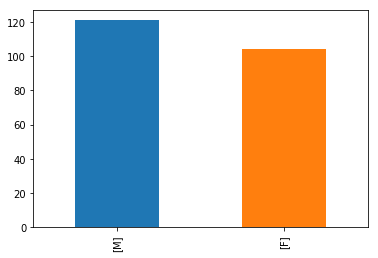

In [54]:
print(df_user_log['gender'].value_counts())
print(df_user_log['gender'].describe())
ax = plt.gca()
#df_user_log['gender'].value_counts().plot(kind='bar', position = 1, ax=ax)
#df_user_log.groupby(["Churn"])['gender'].value_counts().plot(kind='bar', ax=ax)
df_user_log.groupby(["Churn", 'userId'])['gender'].unique().value_counts().plot(kind='bar')

In [55]:
#ax = plt.gca()
#df_user_log['gender'].value_counts().plot(kind='bar', position = 1, ax=ax)
#VISUALIZE
#figsize = (15, 20)
#fontsize = 17
#fig,axes = plt.subplots(nrows=5, ncols=1, figsize=figsize)
#fig.subplots_adjust(top=5, bottom = 2.5, hspace= 1, wspace = 13)
#df_user_log[df_user_log["Churn"] == 'true']['location'].value_counts().plot(kind='bar', ax=axes[0])
#df_user_log[df_user_log["Churn"] == 'false']['location'].value_counts().plot(kind='bar', ax=axes[1])

In [56]:
df_user_log.groupby(["page"])['gender'].value_counts().plot(kind='bar', ax=ax)

In [57]:
import pandas as pd
churn_usr_songs.hour = pd.to_numeric(churn_usr_songs.hour)
grp = churn_usr_songs.groupby('Churn')
grp.groups
#grp.get_group('true').plot(x ='hour' , y = 'count')
#['hour', 'count'].plot()
#plt.plot(churn_usr_songs['hour'] , churn_usr_songs['count'])

{'0': Int64Index([ 0,  2,  5,  7,  9, 10, 12, 15, 16, 19, 20, 23, 25, 26, 29, 31, 33,
             35, 36, 38, 40, 42, 44, 47],
            dtype='int64'),
 '1': Int64Index([ 1,  3,  4,  6,  8, 11, 13, 14, 17, 18, 21, 22, 24, 27, 28, 30, 32,
             34, 37, 39, 41, 43, 45, 46],
            dtype='int64')}

In [58]:
import matplotlib.pyplot as plt

def explore_data(df, target_col, exit):
    num = df.select([target_col]).filter(df.Churn == exit).dropDuplicates().count()
    return num


def plot_pie_chart(data1, data2, label1= 'Churned', label2='Not Churned'):
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
 labels = label1, label2
 sizes = [data1, data2]
 explode = (0, 0.1)  # only "explode" the 2nd slice - churned users

 fig1, ax1 = plt.subplots()
 ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
 ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

 plt.show()

In [59]:
total_users = user_log.select("userId").dropDuplicates().count()

num_churned_user    = explore_data(user_log, "userId", "1")
num_non_churned_user = explore_data(user_log,"userId", "0")

num_males    = user_log.select(["userId"]).filter(user_log.gender == "M").dropDuplicates().count()
num_females  = user_log.select(["userId"]).filter(user_log.gender == "F").dropDuplicates().count()
loc = user_log.select(["location"]).dropDuplicates().count()
print(loc)
#num_non_churned_user = user_log.select(["userId"]).filter(user_log.Churn == "false").dropDuplicates().count()

114


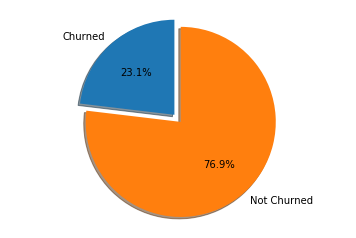

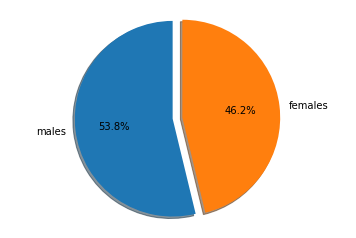

TOTAL USERS 225
CHURNED USERS: 52
NON CHURNED USERS 173


In [60]:
plot_pie_chart(num_churned_user, num_non_churned_user)
plot_pie_chart(num_males, num_females, 'males', 'females')


print("TOTAL USERS", total_users)
print("CHURNED USERS:",    num_churned_user)
print("NON CHURNED USERS", num_non_churned_user)

In [61]:
#https://www.kaggle.com/bandiang2/prediction-of-customer-churn-at-a-bank

churn    = df_user_log[df_user_log["Churn"] == '1']
not_churn= df_user_log[df_user_log["Churn"] == '0']

#function  for pie plot for customer attrition types
import plotly.graph_objs as go #visualization
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)
#for all categorical columns plot pie
#for i in cat_cols :
    #plot_pie(i)

In [62]:
def get_total_number(df, cat_col, new_col):
 df[new_col] = df.groupby('userId')[cat_col].transform('sum')
 return df

def trend_over_time(df, eventcol, eventtype, time , xtitle , ytitle , kind = 'bar'):
    fig1, ax1 = plt.subplots(1,2)
    figsize=(12,5)
    
    ax1[0].set_xlabel(xtitle, fontsize=13)
    ax1[0].set_ylabel(ytitle, fontsize= 13)
    
    ax1[1].set_xlabel('Month', fontsize=13)
    ax1[1].set_ylabel('Non Chruned', fontsize= 13)
    
    y = df[df['Churn'] == '1'][[eventcol, time]]
    y[y[eventcol] == eventtype][time].value_counts(normalize=False).plot(kind=kind, use_index=True, figsize=figsize, ax=ax1[0])
    s = df[df['Churn'] == '0'][[eventcol, time]]
    s[s[eventcol] == eventtype][time].value_counts(normalize=False).plot(kind=kind, use_index=True, figsize=figsize, ax=ax1[1])

In [63]:
cat_col_names = df_user_log['page'].unique()
cat_col_names = list(cat_col_names)

tt = pd.get_dummies(df_user_log, columns=['gender', 'page'])

#print(tt.info())
for name in cat_col_names:
 tt = get_total_number(tt, 'page_'+name,'num_'+name)

(225, 62)
Index(['artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length',
       'level', 'location', 'method', 'registration', 'sessionId', 'song',
       'status', 'ts', 'userAgent', 'userId', 'Churn', 'hour', 'month', 'time',
       'day', 'year', 'gender_F', 'gender_M', 'page_About', 'page_Add Friend',
       'page_Add to Playlist', 'page_Cancel', 'page_Cancellation Confirmation',
       'page_Downgrade', 'page_Error', 'page_Help', 'page_Home', 'page_Logout',
       'page_NextSong', 'page_Roll Advert', 'page_Save Settings',
       'page_Settings', 'page_Submit Downgrade', 'page_Submit Upgrade',
       'page_Thumbs Down', 'page_Thumbs Up', 'page_Upgrade', 'num_NextSong',
       'num_Add to Playlist', 'num_Roll Advert', 'num_Thumbs Up',
       'num_Downgrade', 'num_Thumbs Down', 'num_Home', 'num_Logout',
       'num_Help', 'num_Upgrade', 'num_Add Friend', 'num_Settings',
       'num_Submit Upgrade', 'num_About', 'num_Submit Downgrade', 'num_Error',
       'num_Save Setti

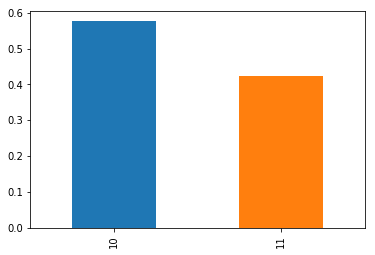

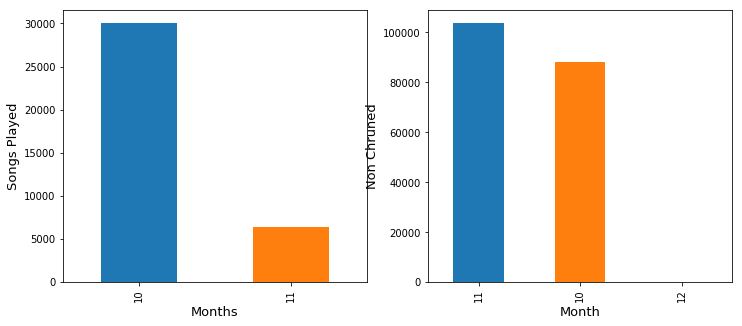

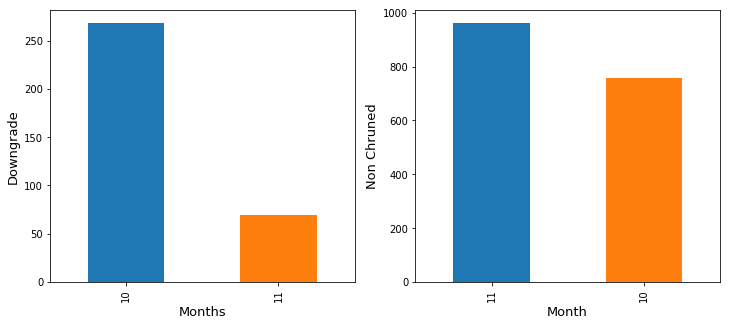

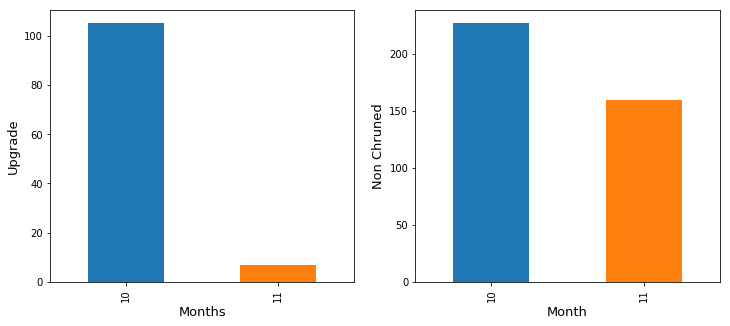

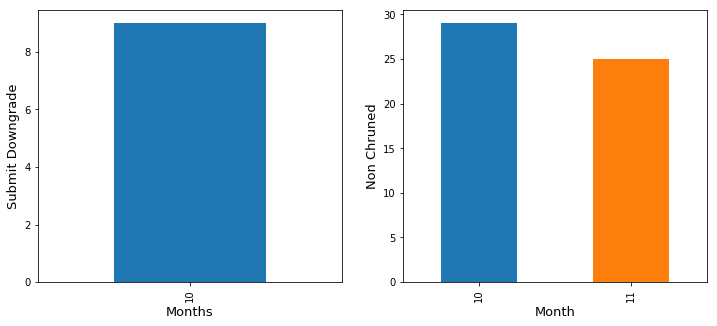

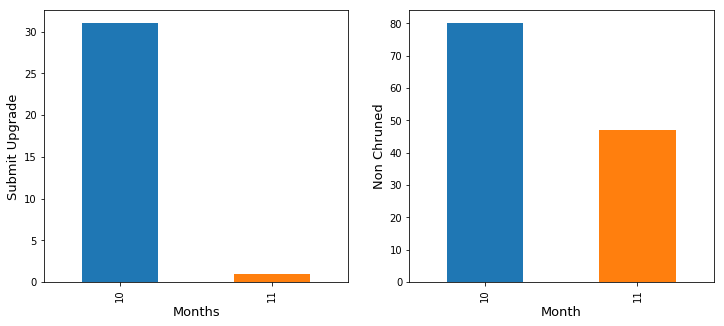

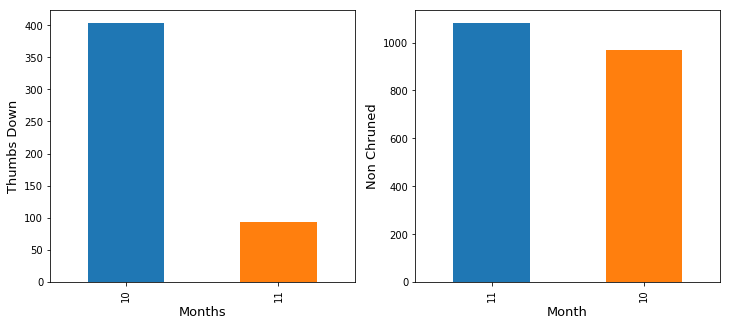

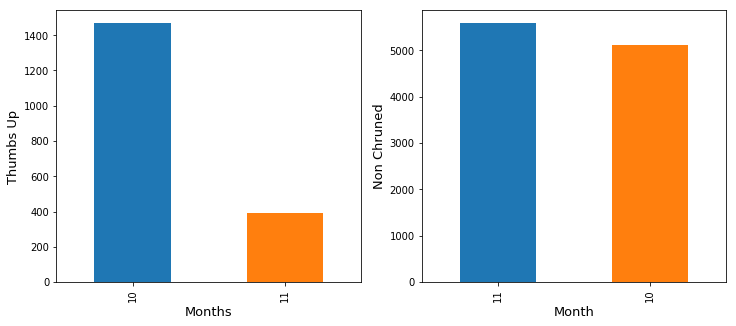

In [64]:
tt = tt.drop_duplicates(subset=['userId'], keep='first')
print(tt.shape)
x = df_user_log[df_user_log['page'] == 'Cancellation Confirmation'][['day', 'month']]
#y = df_user_log[df_user_log['Churn'] == '1'][['page', 'month']]

print(tt.columns)
x
x['month'].value_counts(sort=False, normalize=True).plot(kind='bar', use_index=True)
trend_over_time(df_user_log, 'page' , 'NextSong' , 'month' , 'Months' , 'Songs Played')
trend_over_time(df_user_log, 'page' , 'Downgrade', 'month' , 'Months' , 'Downgrade')
trend_over_time(df_user_log, 'page' , 'Upgrade', 'month' , 'Months' , 'Upgrade')
trend_over_time(df_user_log, 'page' , 'Submit Downgrade', 'month' , 'Months' , 'Submit Downgrade')
trend_over_time(df_user_log, 'page' , 'Submit Upgrade', 'month' , 'Months' , 'Submit Upgrade')
trend_over_time(df_user_log, 'page' , 'Thumbs Down', 'month' , 'Months' , 'Thumbs Down')
trend_over_time(df_user_log, 'page' , 'Thumbs Up', 'month' , 'Months' , 'Thumbs Up')


#y[y['page'] == 'NextSong']['month'].value_counts().plot(kind='bar', use_index=True)

In [65]:
plot_pie('gender')

In [66]:
plot_pie('page')

In [67]:
cols_to_plot=  []
#fig, ax = plt.subplots(2, 1, figsize=(14, 4))
#fig,ax = plt.subplots()
for name in cat_col_names:
  cols_to_plot.append('num_'+name)

print(cols_to_plot)
#tt.hist(column=cols_to_plot , bins=15, color="blue", alpha=0.5, figsize=(20,20))  


#mgrp = tt[tt['num_Cancellation Confirmation'] == 1].groupby('month')
#mgrp.groups
#for m in mgrp.groups:
# print(m)

#tt.groupby('Churn')['num_Downgrade'].hist(bins=15, color="blue", alpha=0.5, figsize=(20,20), ax=ax)  
#tt['num_dngrade'] = tt.groupby('userId')['page_Downgrade'].transform('sum')

['num_NextSong', 'num_Add to Playlist', 'num_Roll Advert', 'num_Thumbs Up', 'num_Downgrade', 'num_Thumbs Down', 'num_Home', 'num_Logout', 'num_Help', 'num_Upgrade', 'num_Add Friend', 'num_Settings', 'num_Submit Upgrade', 'num_About', 'num_Submit Downgrade', 'num_Error', 'num_Save Settings', 'num_Cancel', 'num_Cancellation Confirmation']


(225, 19)


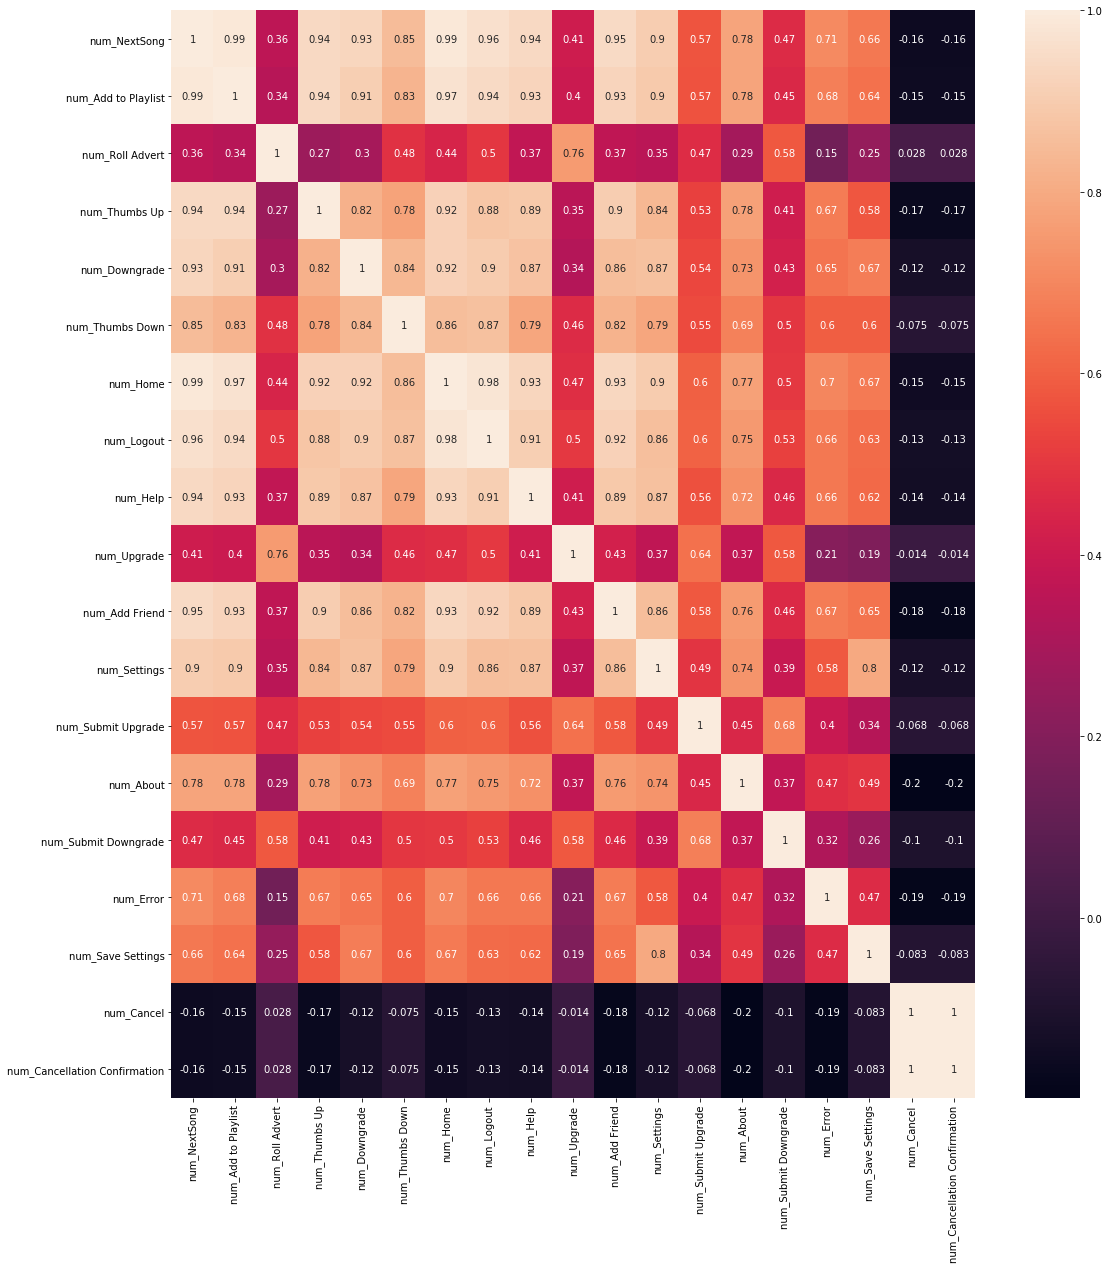

In [68]:
import seaborn as sn

fig, ax = plt.subplots(figsize=(18,20))  

#cols_to_plot.append('Churn')

df_tmp = tt[cols_to_plot]
#df_tmp = tt[tt['Churn'] == 1]
print(df_tmp.shape)
#print(df_tmp['Churn'].head())
corrMatrix= df_tmp[cols_to_plot].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [69]:
print(df_user_log[df_user_log['userId']== '18'][['userId', 'level', 'month', 'page']])


      userId level  month                       page
4622      18  paid     10                       Home
4625      18  paid     10                   NextSong
4632      18  paid     10                   NextSong
4641      18  paid     10                   NextSong
4650      18  paid     10                   NextSong
4659      18  paid     10                   NextSong
4660      18  paid     10                   Settings
4666      18  paid     10                   NextSong
4679      18  paid     10                   NextSong
4684      18  paid     10                   NextSong
4695      18  paid     10                   NextSong
4702      18  paid     10                   NextSong
4703      18  paid     10                   Settings
4707      18  paid     10                   NextSong
4717      18  paid     10                   NextSong
4726      18  paid     10                   NextSong
4733      18  paid     10                   NextSong
4737      18  paid     10                   Ne

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [70]:
tt[tt.isna()].count()
tt.columns
#tt['Churn'] = pd.to_numeric(tt['Churn'])
tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 252939
Data columns (total 62 columns):
artist                            110 non-null object
auth                              225 non-null object
firstName                         225 non-null object
itemInSession                     225 non-null int64
lastName                          225 non-null object
length                            110 non-null float64
level                             225 non-null object
location                          225 non-null object
method                            225 non-null object
registration                      225 non-null int64
sessionId                         225 non-null int64
song                              110 non-null object
status                            225 non-null int64
ts                                225 non-null int64
userAgent                         225 non-null object
userId                            225 non-null object
Churn                           

In [71]:
feature_df_pd = tt[['userId', 'num_NextSong', 
                   'num_Add to Playlist',
                   'num_Roll Advert',
                   'num_Thumbs Up', 
                   'num_Downgrade' , 
                   'num_Thumbs Down',
                   'num_Home', 
                   'num_Logout',
                   'num_Help',
                   'num_Upgrade',
                   'num_Add Friend',
                   'num_Settings',
                   'num_Submit Upgrade',
                   'num_About',
                   'num_Submit Downgrade',
                   'num_Error',
                   'num_Save Settings',
                   'Churn']]
feature_df_pd.head()

,userId,num_NextSong,num_Add to Playlist,num_Roll Advert,num_Thumbs Up,num_Downgrade,num_Thumbs Down,num_Home,num_Logout,num_Help,num_Upgrade,num_Add Friend,num_Settings,num_Submit Upgrade,num_About,num_Submit Downgrade,num_Error,num_Save Settings,Churn
0,30,1417.0,47,72,62.0,6,17,70.0,20,5,14,25,13,1,3,1,1,1,0
1,9,2676.0,77,16,118.0,32,32,117.0,34,15,6,40,12,2,9,1,3,1,0
17,74,2400.0,80,22,135.0,31,25,84.0,25,13,3,43,17,2,4,1,1,1,0
22,54,2841.0,72,47,163.0,39,29,129.0,36,17,1,33,17,1,5,1,1,3,1
70,4,2048.0,59,4,95.0,21,26,80.0,24,12,4,46,10,1,6,0,4,2,0


In [72]:
feature_spark_df = spark.createDataFrame(feature_df_pd)
print(len(cat_col_names))

19


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [73]:
feature_spark_df.columns[1:18]

['num_NextSong',
 'num_Add to Playlist',
 'num_Roll Advert',
 'num_Thumbs Up',
 'num_Downgrade',
 'num_Thumbs Down',
 'num_Home',
 'num_Logout',
 'num_Help',
 'num_Upgrade',
 'num_Add Friend',
 'num_Settings',
 'num_Submit Upgrade',
 'num_About',
 'num_Submit Downgrade',
 'num_Error',
 'num_Save Settings']

In [134]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.feature import StringIndexer 
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator    
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

In [122]:
def get_accuracy(result):
 true_pred_count = result.filter(result.label == result.prediction).count()
 print("Correct prediction:", true_pred_count)
 print("Total values:", result.count())
 print("Accuracy:" ,true_pred_count/result.count())

In [123]:
def get_eval_metrics(df):
 predictionRDD = df.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
 metrics = MulticlassMetrics(predictionRDD)
 print("Precision:", metrics.precision())
 print("Accuracy:", metrics.accuracy)
 print("Recall:", metrics.recall())
 print("F1:", metrics.fMeasure())  
 print("Weighted Precision:",metrics.weightedPrecision)
 print("Weighted Recall:",metrics.weightedRecall)
 print("Weighted F1:",metrics.weightedFMeasure())

In [124]:
def config_pipeline(assembler, scaler, indexer,model):
    pipeline = Pipeline(stages=[assembler, scaler, indexer, model])
    return pipeline


In [ ]:
(trainingData, testData) = feature_spark_df.randomSplit([0.7, 0.3])

In [139]:
assembler = VectorAssembler(inputCols=feature_spark_df.columns[1:18], outputCol="features")
scaler    = StandardScaler(inputCol="features", outputCol="scaled_features")
indexer = StringIndexer(inputCol="Churn", outputCol="label")

#Define all the algorithms which we are going to use
rf           = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=5, numTrees=20)
logistic_reg = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'label', maxIter=50)
d_tree       = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'label', maxDepth = 5)
grad_bt      = GBTClassifier(maxIter=50)

# Select (prediction, true label) and compute test error
#evaluator = BinaryClassificationEvaluator(labelCol="Churn")
evaluator = BinaryClassificationEvaluator()

In [143]:
#RandomForest
pipeline_rf = config_pipeline(assembler, scaler, indexer,rf)

pmodel = pipeline_rf.fit(trainingData)
result = pmodel.transform(testData)
#result.printSchema()
eval_result  = evaluator.evaluate(result)
#eval_metric = BinaryClassificationMetrics(result)

print(eval_result)
get_accuracy(result)
get_eval_metrics(result)


0.6033163265306122
Correct prediction: 56
Total values: 70
Accuracy: 0.8
Precision: 0.8
Accuracy: 0.8
Recall: 0.8
F1: 0.8
Weighted Precision: 0.7545454545454545
Weighted Recall: 0.8
Weighted F1: 0.7526411657559199


In [127]:
#c =result.toPandas()
#c[['userId', 'label' , 'probability' , 'rawPrediction', 'prediction']].head(20)

In [141]:
#Gradient BT Classifier

pipeline_grad  = config_pipeline(assembler, scaler, indexer,grad_bt)
grad_model     = pipeline_grad.fit(trainingData)
grad_pred      = grad_model.transform(testData)
evaluator.evaluate(grad_pred)
get_eval_metrics(grad_pred)


Precision: 0.7571428571428571
Accuracy: 0.7571428571428571
Recall: 0.7571428571428571
F1: 0.7571428571428571
Weighted Precision: 0.7371340523882897
Weighted Recall: 0.7571428571428571
Weighted F1: 0.7457391304347827


In [128]:
#Logistic Regression 
pipeline_lr    =  config_pipeline(assembler, scaler, indexer,logistic_reg)
lrModel        = pipeline_lr.fit(trainingData)
lrModel_pred = lrModel.transform(testData)
eval_result  = evaluator.evaluate(lrModel_pred)
get_eval_metrics(lrModel_pred)
print("Evaluator Result:",eval_result)

Precision: 0.7
Accuracy: 0.7
Recall: 0.7
F1: 0.7
Weighted Precision: 0.6517304189435337
Weighted Recall: 0.7
Weighted F1: 0.6738015607580825
Evaluator Result: 0.4706632653061225


In [129]:
get_accuracy(lrModel_pred)

Correct prediction: 49
Total values: 70
Accuracy: 0.7


In [140]:
#Decesion Tree
pipeline_dt   =  config_pipeline(assembler, scaler, indexer,d_tree)
dtModel = pipeline_dt.fit(trainingData)
dt_pred = dtModel.transform(testData)
eval_result  = evaluator.evaluate(dt_pred)
get_eval_metrics(dt_pred)
print("Evaluator Result:",eval_result)
get_accuracy(dt_pred)

Precision: 0.7285714285714285
Accuracy: 0.7285714285714285
Recall: 0.7285714285714285
F1: 0.7285714285714285
Weighted Precision: 0.7053929121725733
Weighted Recall: 0.7285714285714285
Weighted F1: 0.7158260869565218
Evaluator Result: 0.5803571428571428
Correct prediction: 51
Total values: 70
Accuracy: 0.7285714285714285


In [131]:
rfModel = pmodel.stages[3]
importances = rfModel.featureImportances
#gives sparse vector
importances
features_label = feature_df_pd.columns
import numpy as np
indices = np.argsort(importances)[::-1]
indices
importances[int(indices[1])]

for i in range(1,feature_df_pd.shape[1] -1):     
   print ("%2d) %-*s %f" % (i + 1, 30, features_label[i], importances[int(indices[i])] )) 
   #print(features_label[i], importances[indices[i]]) 

 2) num_NextSong                   0.108701
 3) num_Add to Playlist            0.104067
 4) num_Roll Advert                0.096028
 5) num_Thumbs Up                  0.094013
 6) num_Downgrade                  0.083909
 7) num_Thumbs Down                0.060771
 8) num_Home                       0.060200
 9) num_Logout                     0.059966
10) num_Help                       0.059130
11) num_Upgrade                    0.045616
12) num_Add Friend                 0.042150
13) num_Settings                   0.038391
14) num_Submit Upgrade             0.012448
15) num_About                      0.011013
16) num_Submit Downgrade           0.010331
17) num_Error                      0.003795


IndexError: index 17 is out of bounds for axis 0 with size 17

In [142]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [196]:
#paramGrid = (ParamGridBuilder. 
#    .addGrid(rf.numTrees, [3, 10])
#    .addGrid(...)  # Add other parameters
#    .build())
# Set F-1 score as evaluation metric for best model selection
evaluator_ = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol='prediction', metricName='f1')   

#Following two parameters chosen because of recommendation in spark api documentation
paramGrid = ParamGridBuilder() \
           .addGrid(rf.maxDepth, [5,8,10,12]) \
           .addGrid(rf.numTrees, [8,10,12,15,20,25]) \
           .build()

cv = CrossValidator(estimator=pipeline_rf,                         
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_,
                    numFolds=3)  # use 3+ folds in practice

# Train model.  This also runs the indexers.
tuned_model = cv.fit(trainingData)

In [197]:
print(tuned_model.avgMetrics)
info = tuned_model.bestModel.stages[3]
print(info)

[0.6704403338393243, 0.6465040518157463, 0.6062192923823604, 0.6391447779576658, 0.6089178234703874, 0.6351310798374056, 0.6689656914888654, 0.6501192229344794, 0.6037639704595534, 0.6454084873896196, 0.63240309655404, 0.6398595115576247, 0.6614888698315338, 0.6589361546682951, 0.5999658817558043, 0.6497573556565786, 0.6389687531196966, 0.6517387173075833, 0.6657715649629395, 0.6589361546682951, 0.5999658817558043, 0.6454084873896196, 0.6389687531196966, 0.6517387173075833]
RandomForestClassificationModel (uid=RandomForestClassifier_ad90ac8883c4) with 8 trees


In [198]:
tuned_results = tuned_model.transform(testData)

In [199]:
print(tuned_results.filter(tuned_results.label == tuned_results.prediction).count())
print(tuned_results.count())

53
70


In [200]:
print (evaluator_.getMetricName(), 'accuracy:', evaluator_.evaluate(tuned_results))

f1 accuracy: 0.7086559373640713


In [190]:
get_eval_metrics(tuned_results)

Precision: 0.8
Accuracy: 0.8
Recall: 0.8
F1: 0.8
Weighted Precision: 0.64
Weighted Recall: 0.8
Weighted F1: 0.7111111111111111


In [ ]:

#tree_model = CV_model.bestModel.stages[2]
#print tree_model

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.